In [18]:
import pandas as pd
import numpy as np
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
import os
import timm
from tqdm.notebook import tqdm # Import tqdm for progress bar

In [19]:
df = pd.read_csv('../data/complete_sculpture_dataset_labeled.csv')
df.head()

,filename,page,group,era,material
0,page188_img01_photo13.jpg,188,SOUNION GROUP,615 - 590 BC,Marble
1,page202_img01_photo3.jpg,202,SOUNION GROUP,615 - 590 BC,Marble
2,page202_img01_photo4.jpg,202,SOUNION GROUP,615 - 590 BC,Marble
3,page205_img01_photo4.jpg,205,SOUNION GROUP,615 - 590 BC,Marble
4,page211_img01_photo12.jpg,211,SOUNION GROUP,615 - 590 BC,Lead


In [20]:
model_name = 'convnextv2_tiny' 
model = timm.create_model(model_name, pretrained=True)
model.eval()  # set to eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kaiyan Zhang\.cache\huggingface\hub\models--timm--convnextv2_tiny.fcmae_ft_in22k_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): GlobalResponseNormMlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (grn): GlobalResponseNorm()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), 

In [21]:
# Option A: if model.forward_features exists:
def extract_backbone_features(x):
    # x: tensor (B,3,H,W)
    feat_map = model.forward_features(x)  # tensor shape: (B, C, H', W')
    # Usually, to get a single vector per image, apply global pooling:
    # Many timm models have model.global_pool or model.fc (depending on arch).
    # For ConvNeXt, there's often model.global_pool (AdaptiveAvgPool).
    # Check if model.global_pool exists:
    if hasattr(model, 'global_pool'):
        # Apply global pool: 
        pooled = model.global_pool(feat_map)  # shape: (B, C, 1, 1)
        return pooled.view(pooled.size(0), -1)  # shape: (B, C)
    else:
        # Fallback: adaptive avg pool:
        import torch.nn.functional as F
        pooled = F.adaptive_avg_pool2d(feat_map, 1)  # (B, C, 1, 1)
        return pooled.view(pooled.size(0), -1)

# Option B: reset classifier to output feature vectors directly
# This depends on timm model API; many have model.reset_classifier.
try:
    model.reset_classifier(0)  # replace head so output is feature vector
    # Now model(x) returns features of shape (B, C)
    def extract_backbone_features(x):
        return model(x)
except AttributeError:
    # fallback to forward_features approach above
    pass


In [22]:
from torchvision import transforms
from PIL import Image
import os

# ImageNet normalization (mean/std) :contentReference[oaicite:4]{index=4}
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Decide target input size: many ConvNeXt V2 variants use 224×224 or larger (e.g., 384).
input_size = 224  # adjust if your variant expects 384: set 384 accordingly.

preprocess = transforms.Compose([
    transforms.Resize(int(input_size * 1.14)),  # resize shorter side
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

def load_and_preprocess(image_path):
    img = Image.open(image_path).convert('RGB')
    return preprocess(img)


In [23]:
import torch
import numpy as np

def extract_features_from_folder(folder_path, batch_size=16):
    # Collect image file paths
    exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)
                   if fname.lower().endswith(exts)]
    image_paths.sort()
    features_list = []
    filenames = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_imgs = []
            for p in batch_paths:
                try:
                    tensor = load_and_preprocess(p)
                    batch_imgs.append(tensor)
                except Exception as e:
                    print(f"Warning: could not process {p}: {e}")
            if not batch_imgs:
                continue
            batch_tensor = torch.stack(batch_imgs, dim=0).to(device)  # (B,3,H,W)
            feats = extract_backbone_features(batch_tensor)  # (B, feat_dim)
            # Convert to CPU numpy
            feats_np = feats.cpu().numpy()
            features_list.append(feats_np)
            filenames.extend([os.path.basename(p) for p in batch_paths])
    if features_list:
        features = np.concatenate(features_list, axis=0)  # shape (N, feat_dim)
    else:
        features = np.zeros((0,))  # empty
    return filenames, features

# Example usage:
folder = '../data/richter_kouroi_complete_front_only'
filenames, features = extract_features_from_folder(folder, batch_size=8)
print(f"Extracted features for {len(filenames)} images; feature dimension: {features.shape[1]}")


Extracted features for 62 images; feature dimension: 768


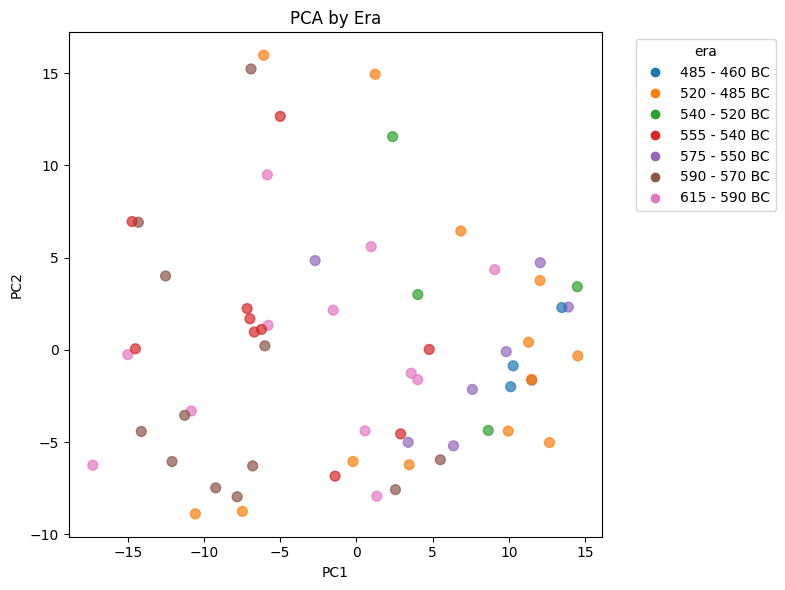

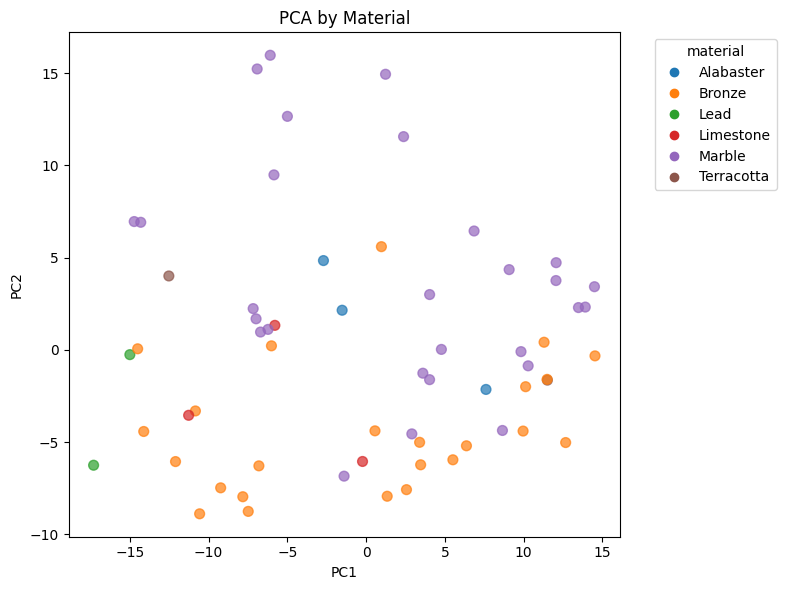

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca_by_metadata(features, filenames, df, category_col='era', title=None, annotate=False):
    """
    Plot PCA of `features`, coloring and optionally annotating points by metadata category.
    
    Args:
        features: numpy array of shape (N, D) - feature vectors.
        filenames: list of length N - filenames corresponding to each feature vector.
        df: pandas DataFrame containing at least columns ['filename', category_col].
        category_col: str - column name in df to color by (e.g., 'era' or 'material').
        title: str or None - plot title.
        annotate: bool - whether to annotate each point with filename or metadata label.
    """
    # Ensure DataFrame has the necessary columns
    if 'filename' not in df.columns or category_col not in df.columns:
        raise ValueError(f"DataFrame must contain 'filename' and '{category_col}' columns.")
    
    # Run PCA
    pca = PCA(n_components=2, random_state=0)
    feats_2d = pca.fit_transform(features)  # shape (N, 2)
    
    # Prepare mapping from filename to category
    # We'll create a dict for faster lookup
    # If DataFrame has duplicates for the same filename, last one will be used
    mapping = dict(zip(df['filename'], df[category_col].astype(str)))
    
    # Get unique categories for colormap
    unique_cats = sorted(df[category_col].astype(str).unique())
    # Create a consistent color map
    cmap = plt.get_cmap('tab10')
    # If more categories than cmap colors, colors will cycle; for many categories, consider a larger colormap
    era_color_map = {cat: cmap(i % cmap.N) for i, cat in enumerate(unique_cats)}
    
    # Build color list and optional labels
    colors = []
    annotations = []
    for fn in filenames:
        cat = mapping.get(fn, None)
        if cat is None:
            # If missing metadata, assign a default color and label
            colors.append('gray')
            annotations.append(f"{fn}\n(Unknown {category_col})")
        else:
            colors.append(era_color_map[cat])
            annotations.append(f"{fn}\n{cat}")
    
    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(feats_2d[:, 0], feats_2d[:, 1], c=colors, s=50, alpha=0.7)
    
    # Create legend manually
    handles = [plt.Line2D([], [], marker="o", ls="", color=era_color_map[cat], label=cat)
               for cat in unique_cats]
    plt.legend(handles=handles, title=category_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    if title is None:
        title = f"PCA colored by {category_col}"
    plt.title(title)
    plt.tight_layout()
    
    # Annotate points if requested
    if annotate:
        for i, text in enumerate(annotations):
            plt.annotate(text, (feats_2d[i, 0], feats_2d[i, 1]),
                         textcoords="offset points", xytext=(3, 3),
                         fontsize=7, color=colors[i])
    
    plt.show()

# Example usage (assuming you have `features`, `filenames`, and `df` defined):
plot_pca_by_metadata(features, filenames, df, category_col='era', title="PCA by Era", annotate=False)
plot_pca_by_metadata(features, filenames, df, category_col='material', title="PCA by Material", annotate=False)

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to C:\Users\Kaiyan Zhang/.cache\torch\hub\checkpoints\convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:09<00:00, 37.6MB/s] 


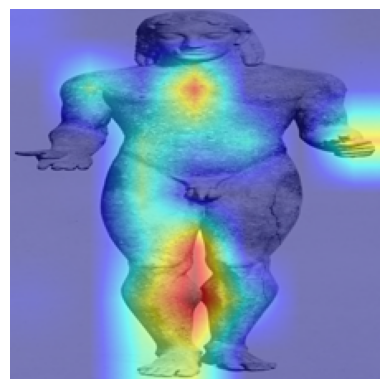

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models import convnext_base
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Load model and image
model = convnext_base(pretrained=True)
model.eval()
target_layers = [model.features[-1]]

# Load and preprocess image
img = Image.open("../data/richter_kouroi_filtered_photos/page312_img01_photo4.jpg").convert("RGB")
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(img).unsqueeze(0)

# GradCAM
from pytorch_grad_cam import GradCAM
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(0)]  # Class index to visualize
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Overlay CAM on image
rgb_img = np.array(img.resize((224, 224))) / 255.0
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.axis("off")
plt.show()

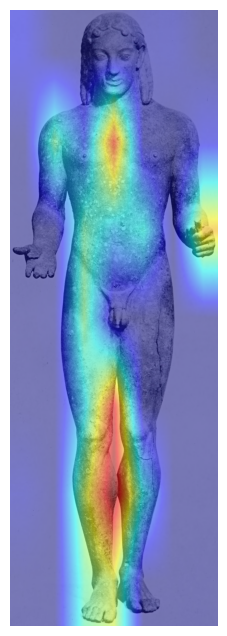

In [33]:
import torch
import torchvision.transforms as T
from torchvision.models import convnext_base
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Load and record original size
orig_img = Image.open("../data/richter_kouroi_filtered_photos/page312_img01_photo4.jpg").convert("RGB")
orig_w, orig_h = orig_img.size
rgb_orig = np.array(orig_img) / 255.0

# 2. Prepare the resized tensor for the model
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(orig_img).unsqueeze(0)

# 3. Load model & CAM setup
model = convnext_base(pretrained=True)
model.eval()
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# 4. Compute the CAM at 224×224
grayscale_cam = cam(input_tensor=input_tensor,
                    targets=[ClassifierOutputTarget(0)])[0]

# 5. Upsample CAM to original size
grayscale_cam_orig = cv2.resize(grayscale_cam, (orig_w, orig_h),
                                interpolation=cv2.INTER_LINEAR)

# 6. Overlay on the original image
visualization = show_cam_on_image(rgb_orig,
                                  grayscale_cam_orig,
                                  use_rgb=True)

# 7. Display
plt.figure(figsize=(8,8))
plt.imshow(visualization)
plt.axis("off")
plt.show()


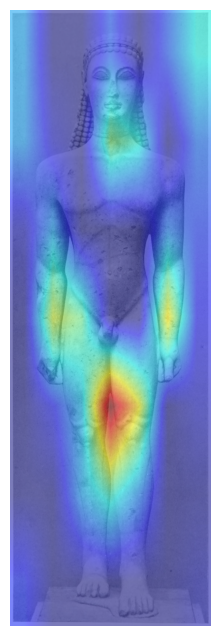

In [34]:
import torch
import torchvision.transforms as T
from torchvision.models import convnext_base
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Load and record original size
orig_img = Image.open("../data/richter_kouroi_filtered_photos/page188_img01_photo13.jpg").convert("RGB")
orig_w, orig_h = orig_img.size
rgb_orig = np.array(orig_img) / 255.0

# 2. Prepare the resized tensor for the model
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(orig_img).unsqueeze(0)

# 3. Load model & CAM setup
model = convnext_base(pretrained=True)
model.eval()
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# 4. Compute the CAM at 224×224
grayscale_cam = cam(input_tensor=input_tensor,
                    targets=[ClassifierOutputTarget(0)])[0]

# 5. Upsample CAM to original size
grayscale_cam_orig = cv2.resize(grayscale_cam, (orig_w, orig_h),
                                interpolation=cv2.INTER_LINEAR)

# 6. Overlay on the original image
visualization = show_cam_on_image(rgb_orig,
                                  grayscale_cam_orig,
                                  use_rgb=True)

# 7. Display
plt.figure(figsize=(8,8))
plt.imshow(visualization)
plt.axis("off")
plt.show()


In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models import convnext_base
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Load sculpture image
orig_img = Image.open("sculpture.jpg").convert("RGB")
orig_w, orig_h = orig_img.size
rgb_orig = np.array(orig_img) / 255.0

# 2. Detect parts with YOLOv8 (assumes classes: 0=face,1=torso,2=hand)
from ultralytics import YOLO
yolo = YOLO("path/to/your/face_torso_hand_yolov8.pt")
detections = yolo.predict(source="sculpture.jpg")[0]  # first image

# 3. Prepare ConvNeXt + GradCAM
model = convnext_base(pretrained=True)
model.eval()
cam = GradCAM(model=model, target_layers=[model.features[-1]])

# 4. Preprocess transform
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
input_tensor = transform(orig_img).unsqueeze(0)

# 5. Compute base CAM once (for class-agnostic) or per class
#    Here we’ll do per class—map YOLO class to a classifier output index
class_to_idx = {0: 0, 1: 1, 2: 2}  # dummy mapping

# Precompute CAM heatmap at 224×224 for each class
cams = {}
for yolo_cls, idx in class_to_idx.items():
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=[ClassifierOutputTarget(idx)])[0]
    # upsample to original size
    cams[yolo_cls] = cv2.resize(grayscale_cam, (orig_w, orig_h),
                                interpolation=cv2.INTER_LINEAR)

# 6. Overlay per-detection
vis = rgb_orig.copy()
for box, score, cls in zip(detections.boxes.xyxy, detections.boxes.conf,
                           detections.boxes.cls):
    x1, y1, x2, y2 = map(int, box.cpu().numpy())
    part_cam = cams[int(cls)]

    # zero-out CAM outside the box
    mask = np.zeros_like(part_cam)
    mask[y1:y2, x1:x2] = part_cam[y1:y2, x1:x2]
    
    # overlay just that masked CAM
    vis = show_cam_on_image(vis, mask, use_rgb=True)

    # draw bounding box
    cv2.rectangle(vis, (x1,y1), (x2,y2), (255,255,255), 2)
    cv2.putText(vis, f"{['face','torso','hand'][int(cls)]} {score:.2f}",
                (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (1,1,1), 2)

# 7. Display full-res result
plt.figure(figsize=(8,8))
plt.imshow(vis)
plt.axis("off")
plt.show()
